In [279]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from datetime import datetime
import pickle
from sklearn.feature_selection import VarianceThreshold, RFE
import statsmodels.api as sm
import seaborn as sns

## `TARGET_B`

### `Load data Numericals - Chi2, Categorical and Target`

In [296]:
numericals = pd.read_csv('data/numericals_chi2.csv')
categoricals = pd.read_csv('data/categorical_cleaned.csv')
targets = pd.read_csv('data/target.csv')

print(f"Numericals shape: {numericals.shape}")
print(f"Categoricals shape: {categoricals.shape}")
print(f"Targets shape: {targets.shape}")

Numericals shape: (95412, 13)
Categoricals shape: (95410, 22)
Targets shape: (95412, 2)


In [297]:
numericals = numericals.drop('Unnamed: 0', axis=1)
categoricals = categoricals.drop('Unnamed: 0', axis=1)

print(f"Numericals shape: {numericals.shape}")
print(f"Categoricals shape: {categoricals.shape}")

Numericals shape: (95412, 12)
Categoricals shape: (95410, 21)


### `Helper functions`

#### `Plot n_neighbors functions`

In [4]:
def oversample():
    target = targets[['TARGET_B']]

    target_b_0 = target[target['TARGET_B'] == 0]
    target_b_1 = target[target['TARGET_B'] == 1]

    target_b_1_oversampled = resample(target_b_1, replace=True, n_samples=len(target_b_0))
    target_b_oversampled = pd.concat([target_b_0, target_b_1_oversampled], axis=0)

    full_df = pd.concat([target_b_oversampled, numericals, categoricals], axis=1).dropna(axis=0).sample(frac=1, random_state=10)

    return full_df['TARGET_B'], full_df.drop('TARGET_B', axis=1)


def plot_n_neighbors(should_oversample):
    full_df = pd.concat([targets[['TARGET_B']], numericals, categoricals], axis=1).dropna(axis=0).sample(frac=1, random_state=10)

    y = full_df['TARGET_B']
    X = full_df.drop('TARGET_B', axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

    if should_oversample == True:
        y_train, X_train = oversample()

    # Scaling data = X_train
    X_train_transformer = MinMaxScaler().fit(X_train)
    X_train_normalized = X_train_transformer.transform(X_train)
    X_train_normalized = pd.DataFrame(X_train_normalized)

    # Scaling data = X_test
    X_test_transformer = MinMaxScaler().fit(X_test)
    X_test_normalized = X_test_transformer.transform(X_test)
    X_test_normalized = pd.DataFrame(X_test_normalized)

    # Try to detect best n_neighbors for KNeighborsRegressor

    train_scores = []
    test_scores = []
    for k in range(2,10):
        print(f"Testing k='{k}'.")
        model = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
        model.fit(X_train, y_train)
        train_scores.append(model.score(X_train, y_train))
        test_scores.append(model.score(X_test, y_test))


    # Plot n_neighbors results for KNeighborsRegressor 

    plt.figure(figsize=(10,6))
    plt.plot(range(2,10),test_scores,color = 'blue', linestyle='dashed',
            marker='o', markerfacecolor='red', markersize=10)
    plt.title('R2-scores vs. K Value')
    plt.gca().invert_yaxis()
    plt.xlabel('K')
    plt.ylabel('Accuracy')
    plt.show()

#### `Compare models functions`

In [83]:
def compare_models(models, should_oversample):
    results = []
    for model in models:

        print(f"====== {model} ======")

        full_df = pd.concat([targets[['TARGET_B']], numericals, categoricals], axis=1).dropna(axis=0).sample(frac=1, random_state=10)

        y = full_df['TARGET_B']
        X = full_df.drop('TARGET_B', axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

        if should_oversample == True:
            y_train, X_train = oversample()

        # Scaling data = X_train
        X_train_transformer = MinMaxScaler().fit(X_train)
        X_train_normalized = X_train_transformer.transform(X_train)
        X_train_normalized = pd.DataFrame(X_train_normalized)

        # Scaling data = X_test
        X_test_transformer = MinMaxScaler().fit(X_test)
        X_test_normalized = X_test_transformer.transform(X_test)
        X_test_normalized = pd.DataFrame(X_test_normalized)

        model.fit(X_train_normalized, y_train)

        results.append(model)

        # Make predictions on the test data
        y_pred = model.predict(X_test_normalized)

        # Calculate the accuracy of the model
        scores = cross_val_score(model, X_train_normalized, y_train, cv=10)
        # Print the mean and standard deviation of the scores
        print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
        
        accuracy = accuracy_score(y_test, y_pred)
        print(f"accuracy: {accuracy}")
        print("precision: ",precision_score(y_test, y_pred))
        print("recall: ",recall_score(y_test, y_pred))
        print("f1: ",f1_score(y_test, y_pred))

        # create confusion matrix
        matrix = confusion_matrix(y_test, y_pred)

        # display confusion matrix
        plt.imshow(matrix, cmap='Blues')
        plt.colorbar()
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        # set tick marks for x-axis and y-axis
        plt.xticks([0,1])
        plt.yticks([0,1])
        # set the tick labels for x-axis and y-axis
        plt.xticks(ticks=[0,1], labels=['Negative', 'Positive'])
        plt.yticks(ticks=[0,1], labels=['Negative', 'Positive'])

        # loop through the cells of the matrix and add the values
        for i in range(2):
            for j in range(2):
                plt.text(j, i, matrix[i, j], ha='center', va='center', color='black', fontsize=20)
        plt.show()

    return results

#### `Find best parameters functions`

In [294]:
def find_best_parameters(model, param_grid):
    grid_search_decision_tree_classifier = GridSearchCV(estimator = model, param_grid = param_grid, cv = 5, n_jobs=-1)

    full_df = pd.concat([targets[['TARGET_B']], numericals, categoricals], axis=1).dropna(axis=0).sample(frac=1, random_state=10)

    y = full_df['TARGET_B']
    X = full_df.drop('TARGET_B', axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

    y_train, X_train = oversample()

    # Scaling data = X_train
    X_train_transformer = MinMaxScaler().fit(X_train)
    X_train_normalized = X_train_transformer.transform(X_train)
    X_train_normalized = pd.DataFrame(X_train_normalized)

    grid_search_decision_tree_classifier.fit(X_train_normalized, y_train)

    print(f"Best parameters: {grid_search_decision_tree_classifier.best_params_}")
    print(f"Best score: {grid_search_decision_tree_classifier.best_score_}")

    return grid_search_decision_tree_classifier

### `Detect best n_neighbors for KNeighborsClassifier`

#### `Plot n_neighbors for imbalanced TARGET_B`

In [ ]:
plot_n_neighbors(should_oversample=False)

In [ ]:
# Best n_neighbors for imbalanced TARGET_B seems 6

#### `Plot n_neighbors for oversampled TARGET_B`

In [ ]:
plot_n_neighbors(should_oversample=True)

In [ ]:
# Best n_neighbors for oversampled TARGET_B seems 2 or 3

### `Compare Algorithms - Random Way`

In [ ]:
models_to_test_imbalanced = [
    DecisionTreeClassifier(),
    KNeighborsClassifier(n_neighbors=6, n_jobs=-1),
    LogisticRegression(solver='lbfgs', multi_class='multinomial', n_jobs=-1)
]

In [ ]:
models_to_test_oversampled = [
    DecisionTreeClassifier(),
    KNeighborsClassifier(n_neighbors=2, n_jobs=-1),
    KNeighborsClassifier(n_neighbors=3, n_jobs=-1),
    LogisticRegression(solver='lbfgs', multi_class='multinomial', n_jobs=-1)
]

#### `Imbalanced TARGET_B`

In [ ]:
compare_models(models=models_to_test_imbalanced, should_oversample=False)

#### `Oversampled TARGET_B`

In [ ]:
compare_models(models=models_to_test_oversampled, should_oversample=True)

In [ ]:
# DecisionTreeClassifier with oversampled TARGET_B performs better in general

### `Looking for best parameters for DecisionTreeClassifier - Hyperparameter search`

In [298]:
grid = {
    'max_depth': [3,10,None],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'min_samples_split': [2,10],
    'min_samples_leaf': [1,2,10],
    'max_features': [None,'auto', 'sqrt', 'log2'],
    'class_weight': [None, 'balanced']
}

grid_search_decision_tree_classifier = find_best_parameters(DecisionTreeClassifier(random_state=10), grid)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
1440 fits failed out of a total of 4320.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1440 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 937, in fit
    super().fit(
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 352, in fit
    criterion = CRITERIA_CLF[self.criterion](
KeyError: 'log_loss'

  warnings.warn(some_fits_fai

Best parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
Best score: 0.9708154162917279


### `Looking for best parameters for LogisticRegression - Hyperparameter search`

In [ ]:
grid = {
    'penalty': [None,'l2','l1','elasticnet'],
    'class_weight': [None, 'balanced'],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'multi_class': ['auto', 'ovr', 'multinomial']
}

grid_search_logistic_regression = find_best_parameters(LogisticRegression(random_state=10, n_jobs=-1), grid)

In [9]:
grid_search_logistic_regression.best_params_

{'class_weight': 'balanced',
 'multi_class': 'auto',
 'penalty': 'l2',
 'solver': 'liblinear'}

In [10]:
grid_search_logistic_regression.best_score_

0.5807112458147083

### `Looking for best parameters for KNeighborsClassifier - Hyperparameter search`

In [ ]:
grid = {
    'n_neighbors': [2, 3, 4, 5, 6],
    'weights': ['uniform', 'distance', None],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}

grid_search_k_neighbors_classifier = find_best_parameters(KNeighborsClassifier(n_jobs=-1), grid)

In [14]:
grid_search_k_neighbors_classifier.best_params_

{'algorithm': 'kd_tree', 'n_neighbors': 2, 'p': 1, 'weights': 'uniform'}

In [15]:
grid_search_k_neighbors_classifier.best_score_

0.9692070735466052

### `Compare DecisionTreeClassifier and KNeighborsClassifier with best parameters`

====== DecisionTreeClassifier() ======
Accuracy: 0.97 (+/- 0.00)
accuracy: 0.9746881878209831
precision:  0.7776497695852534
recall:  0.6994818652849741
f1:  0.7364975450081834


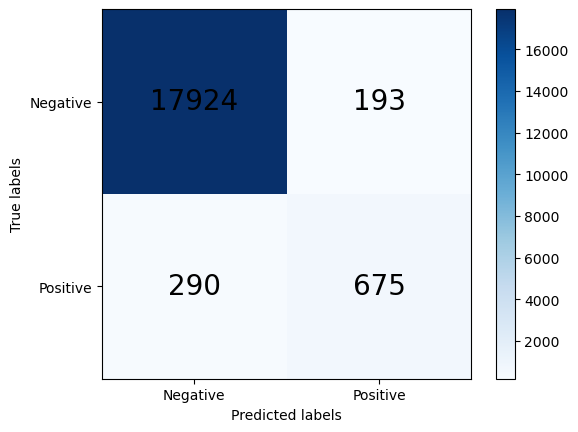

====== DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_features='auto', min_samples_split=10) ======
Accuracy: 0.97 (+/- 0.00)
accuracy: 0.9567131327953045
precision:  0.5674102812803103
recall:  0.6062176165803109
f1:  0.5861723446893788


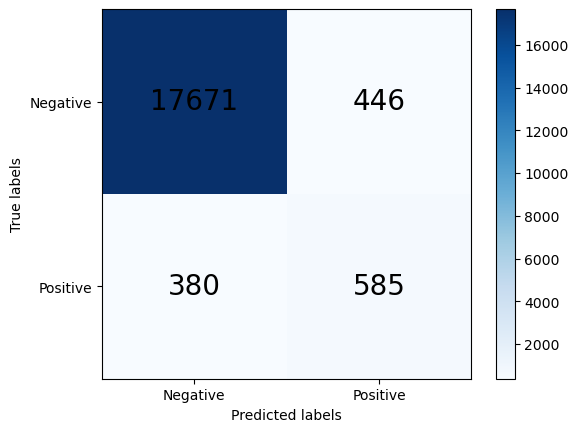

====== DecisionTreeClassifier(class_weight='balanced', max_features='auto') ======
Accuracy: 0.97 (+/- 0.00)
accuracy: 0.9526779163609684
precision:  0.530511811023622
recall:  0.5585492227979275
f1:  0.5441696113074204


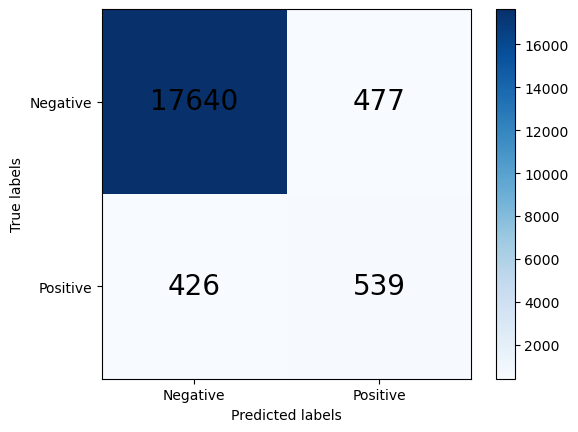

====== KNeighborsClassifier(algorithm='kd_tree', n_jobs=-1, n_neighbors=2, p=1) ======


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

Accuracy: 0.97 (+/- 0.00)
accuracy: 1.0
precision:  1.0
recall:  1.0
f1:  1.0


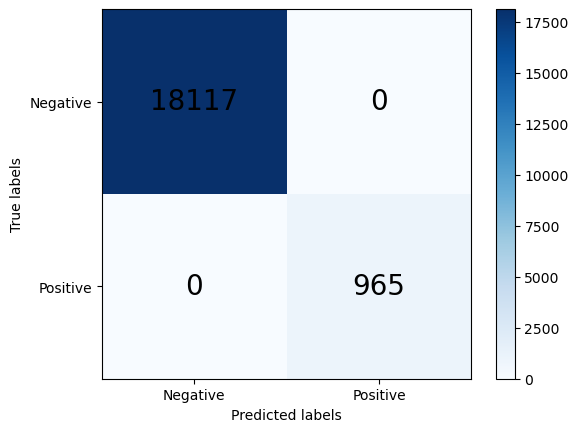

In [84]:
classification_models_to_test_oversampled = [
    DecisionTreeClassifier(),
    DecisionTreeClassifier(class_weight='balanced', criterion='entropy', max_features='auto', min_samples_split=10),
    DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=None, max_features='auto', min_samples_leaf=1, min_samples_split=2, splitter='best'),
    KNeighborsClassifier(algorithm='kd_tree', n_neighbors=2, p=1, weights='uniform', n_jobs=-1)
]

results = compare_models(models=classification_models_to_test_oversampled, should_oversample=True)

In [ ]:
# We will keep DecisionTreeClassifier() for TARGET_B

### `Test on 'real data' - TARGET_B`

In [123]:
def compare_predicted_vs_target_b(model):
    predictions = model.predict(pd.concat([numericals, categoricals], axis=1).dropna(axis=0).values)
    df = pd.concat([targets[['TARGET_B']],pd.Series(predictions, name='TARGET_B_PREDICTED')],axis=1)

    df['EQUAL'] = df['TARGET_B'] == df['TARGET_B_PREDICTED']

    equal_target_b = df[df['EQUAL'] == True]

    print(f"Nb equal values: {len(equal_target_b)}")

In [120]:
results

[DecisionTreeClassifier(),
 DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                        max_features='auto', min_samples_split=10),
 DecisionTreeClassifier(class_weight='balanced', max_features='auto'),
 KNeighborsClassifier(algorithm='kd_tree', n_jobs=-1, n_neighbors=2, p=1)]

In [119]:
# DecisionTreeClassifier()

compare_predicted_vs_target_b(results[0])

Nb equal values: 82809


In [121]:
# DecisionTreeClassifier(class_weight='balanced', criterion='entropy', max_features='auto', min_samples_split=10)

compare_predicted_vs_target_b(results[1])

Nb equal values: 88353


In [122]:
# DecisionTreeClassifier(class_weight='balanced', max_features='auto')

compare_predicted_vs_target_b(results[2])

Nb equal values: 82178


In [117]:
# KNeighborsClassifier(algorithm='kd_tree', n_jobs=-1, n_neighbors=2, p=1)

compare_predicted_vs_target_b(results[3])

/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Nb equals: 89730


### `Save TARGET_B models`

In [126]:
# DecisionTreeClassifier()

current_date = datetime.now().strftime("%Y-%m-%d %H-%M")

with open(f'models/decision_tree_classifier_0_{current_date}.pkl', 'wb') as f:
    pickle.dump(results[0], f)

In [127]:
# DecisionTreeClassifier(class_weight='balanced', criterion='entropy', max_features='auto', min_samples_split=10)

current_date = datetime.now().strftime("%Y-%m-%d %H-%M")

with open(f'models/decision_tree_classifier_1_{current_date}.pkl', 'wb') as f:
    pickle.dump(results[1], f)

In [128]:
# DecisionTreeClassifier(class_weight='balanced', max_features='auto')

current_date = datetime.now().strftime("%Y-%m-%d %H-%M")

with open(f'models/decision_tree_classifier_2_{current_date}.pkl', 'wb') as f:
    pickle.dump(results[2], f)

In [129]:
# KNeighborsClassifier(algorithm='kd_tree', n_jobs=-1, n_neighbors=2, p=1)

current_date = datetime.now().strftime("%Y-%m-%d %H-%M")

with open(f'models/k_neighbors_classifier_{current_date}.pkl', 'wb') as f:
    pickle.dump(results[3], f)

### `Load TARGET_B models`

In [130]:
with open(f'models/decision_tree_classifier_0_2023-01-22 18-02.pkl', "rb") as f:
    decision_tree_classifier_0_model = pickle.load(f)

with open(f'models/decision_tree_classifier_1_2023-01-22 18-03.pkl', "rb") as f:
    decision_tree_classifier_1_model = pickle.load(f)

with open(f'models/decision_tree_classifier_2_2023-01-22 18-03.pkl', "rb") as f:
    decision_tree_classifier_2_model = pickle.load(f)

with open(f'models/k_neighbors_classifier_2023-01-22 18-03.pkl', "rb") as f:
    k_neighbors_classifier_model = pickle.load(f)

## `TARGET_D`

### `Helper functions`

#### `Display Heatmeap`

In [146]:
def display_heatmap(dataframe):
    corr=dataframe.corr()

    mask=np.triu(np.ones_like(corr, dtype=bool))     # generate a mask for the upper triangle

    f, ax=plt.subplots(figsize=(11, 9))                 # set up the matplotlib figure

    cmap=sns.diverging_palette(220, 10, as_cmap=True)   # generate a custom diverging colormap

    sns.heatmap(corr, mask=mask, cmap=cmap,             # draw the heatmap with the mask and correct aspect ratio
                vmax=.3, center=0, square=True,
                linewidths=.5, cbar_kws={"shrink": .5})

#### `Compare models`

In [220]:
def compare_models_target_d(models, selected_numericals):
    results = []
    for model in models:

        print(f"====== {model} ======")

        full_df = pd.concat([targets[['TARGET_D']], selected_numericals, categoricals], axis=1).dropna(axis=0).sample(frac=1, random_state=10)

        y = full_df['TARGET_D']
        X = full_df.drop('TARGET_D', axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

        # Scaling data = X_train
        X_train_transformer = MinMaxScaler().fit(X_train)
        X_train_normalized = X_train_transformer.transform(X_train)
        X_train_normalized = pd.DataFrame(X_train_normalized)

        # Scaling data = X_test
        X_test_transformer = MinMaxScaler().fit(X_test)
        X_test_normalized = X_test_transformer.transform(X_test)
        X_test_normalized = pd.DataFrame(X_test_normalized)

        model.fit(X_train_normalized, y_train)

        results.append(model)

        # Make predictions on the test data
        y_pred = model.predict(X_test_normalized)

        # R2 validation
        r2 = r2_score(y_test, y_pred)
        print("R2:", r2)

        # MSE validation
        mse=mean_squared_error(y_test, y_pred)
        print("Mean Squared Error:", mse)

        # RMSE validation
        # rmse=np.sqrt(y_test, y_pred)
        # print("Root Mean Squared Error:", rmse)

        # MAE validation
        mae=mean_absolute_error(y_test, y_pred)
        print("Mean Absolute Error:", mae)

    return results

#### `Find best parameters`

In [304]:
def find_best_parameters_target_d(model, selected_numericals, param_grid):
    grid_search_decision_tree_classifier = GridSearchCV(estimator = model, param_grid = param_grid, cv = 5, n_jobs=-1)

    full_df = pd.concat([targets[['TARGET_D']], selected_numericals, categoricals], axis=1).dropna(axis=0).sample(frac=1, random_state=10)

    y = full_df['TARGET_D']
    X = full_df.drop('TARGET_D', axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

    # Scaling data = X_train
    X_train_transformer = MinMaxScaler().fit(X_train)
    X_train_normalized = X_train_transformer.transform(X_train)
    X_train_normalized = pd.DataFrame(X_train_normalized)

    grid_search_decision_tree_classifier.fit(X_train_normalized, y_train)

    print(f"Best parameters: {grid_search_decision_tree_classifier.best_params_}")
    print(f"Best score: {grid_search_decision_tree_classifier.best_score_}")

    return grid_search_decision_tree_classifier

### `Select best features`

In [299]:
numericals = pd.read_csv('data/numerical.csv')
categoricals = pd.read_csv('data/categorical_cleaned.csv')
targets = pd.read_csv('data/target.csv')

print(f"Numericals shape: {numericals.shape}")
print(f"Categoricals shape: {categoricals.shape}")
print(f"Targets shape: {targets.shape}")

Numericals shape: (95412, 315)
Categoricals shape: (95410, 22)
Targets shape: (95412, 2)


In [300]:
# Filter targets dataframe

targets = targets[targets.TARGET_B == 1]
categoricals = pd.concat([targets, categoricals], axis=1).dropna(axis=0).drop('TARGET_D', axis=1)
numericals = pd.concat([targets, numericals], axis=1).dropna(axis=0).drop('TARGET_D', axis=1)

print(f"Numericals shape: {numericals.shape}")
print(f"Categoricals shape: {categoricals.shape}")
print(f"Targets shape: {targets.shape}")

Numericals shape: (4843, 316)
Categoricals shape: (4842, 23)
Targets shape: (4843, 2)


In [301]:
important_columns = ['WEALTH1', 'WEALTH2', 'VETERANS', 'SOLIH']

In [302]:
min_max_scaler = MinMaxScaler()
numericals_scaled = min_max_scaler.fit_transform(numericals)

#### `Variance Threshold`

In [261]:
selector = VarianceThreshold(0.05)
selected_numericals = selector.fit_transform(numericals_scaled)

columns_to_drop = [col_tuple[0] for col_tuple in zip(numericals.columns, selector.get_support()) if col_tuple[1] == False]

print(f"There are '{len(columns_to_drop)}' columns to drop.")

There are '280' columns to drop.


In [262]:
columns_to_drop = [col for col in columns_to_drop if col not in important_columns]
numericals_variance = numericals.drop(columns_to_drop, axis=1)
numericals_variance.shape

(4843, 36)

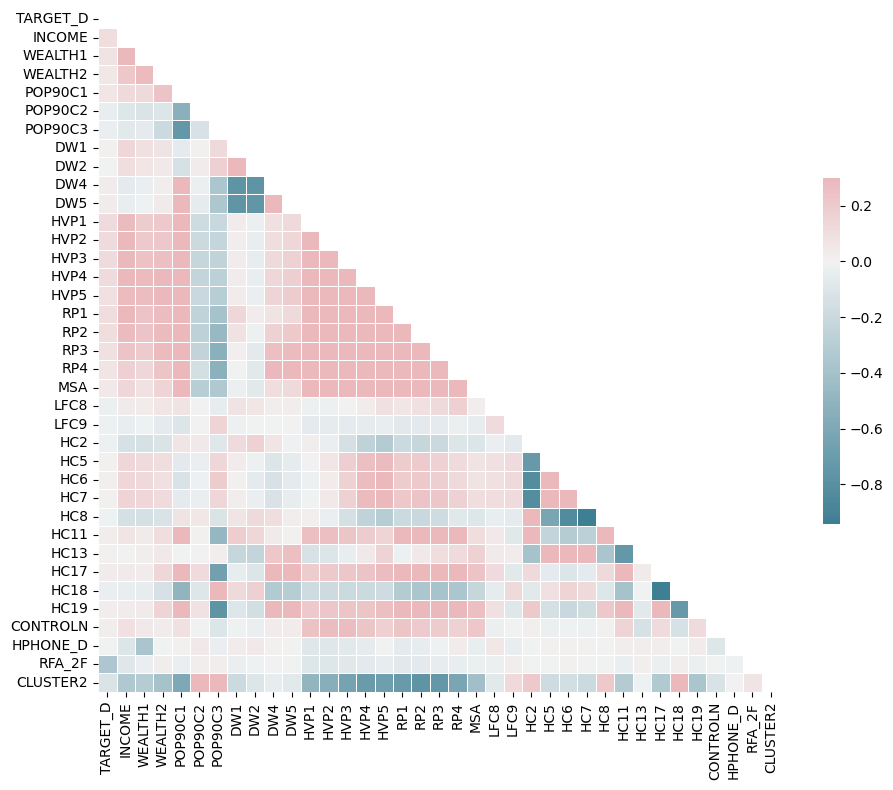

In [263]:
display_heatmap(pd.concat([targets[['TARGET_D']], numericals_variance], axis=1))

In [264]:
numericals_variance_manual_drop = numericals_variance.drop(['POP90C3', 'DW4', 'DW5', 'HC5', 'HC6', 'HC7', 'HC17'], axis=1)
numericals_variance_manual_drop.shape

(4843, 29)

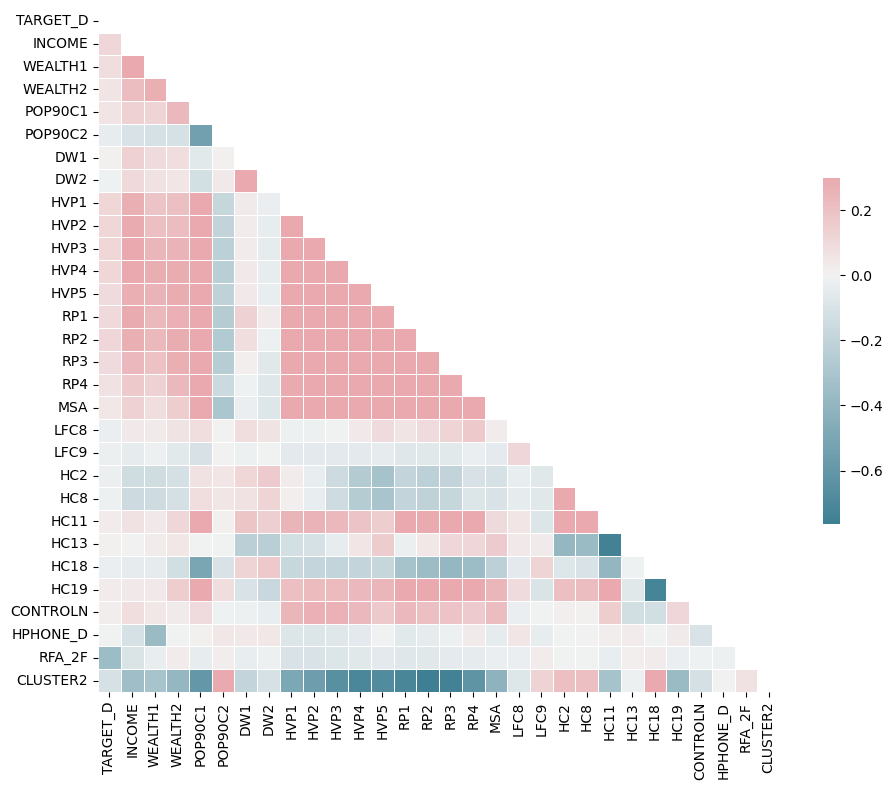

In [265]:
display_heatmap(pd.concat([targets[['TARGET_D']], numericals_variance_manual_drop], axis=1))

#### `RFE`

In [266]:
model = LinearRegression()

# Create an instance of the RFE class
rfe = RFE(model, n_features_to_select=25, verbose=False)

# Fit the RFE to the DataFrame
rfe.fit(numericals_scaled, targets[['TARGET_D']])

# Get the boolean mask of the selected columns
mask = rfe.support_

# Use the mask to obtain the names of the selected columns
columns_to_drop = numericals.columns[~mask]

print(f"There are '{len(columns_to_drop)}' columns to drop.")

There are '291' columns to drop.


In [267]:
columns_to_drop = [col for col in columns_to_drop if col not in important_columns]
numericals_rfe = numericals.drop(columns_to_drop, axis=1)
numericals_rfe.shape

(4843, 27)

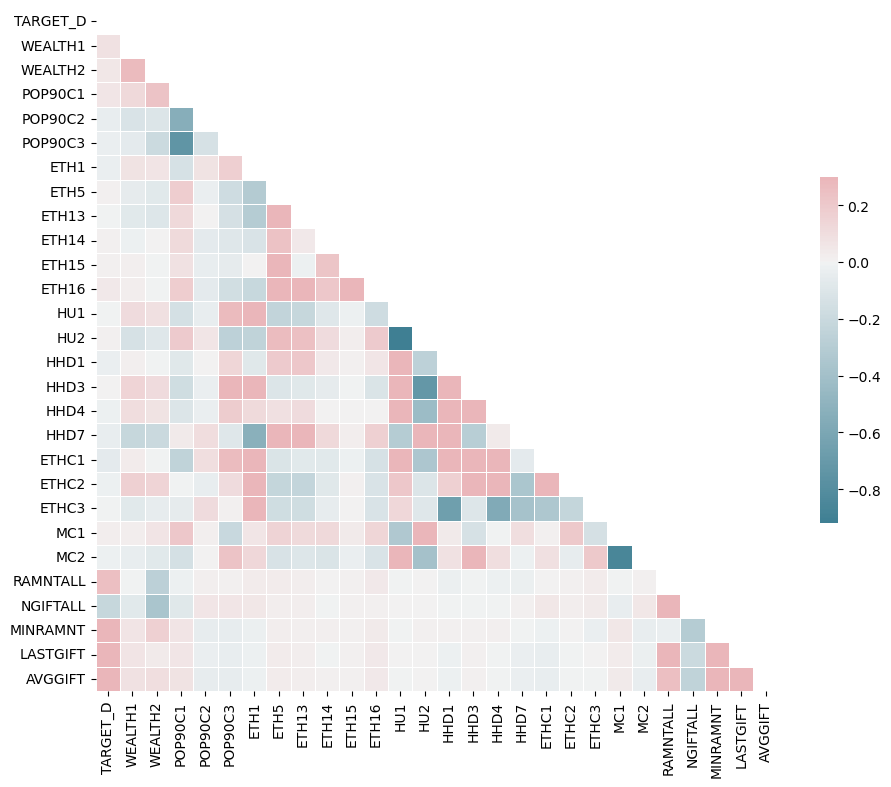

In [268]:
display_heatmap(pd.concat([targets[['TARGET_D']], numericals_rfe], axis=1))

In [275]:
numericals_rfe_manual_drop = numericals_rfe.drop(['POP90C3', 'MC2', 'HU1'], axis=1)
numericals_rfe_manual_drop.shape

(4843, 24)

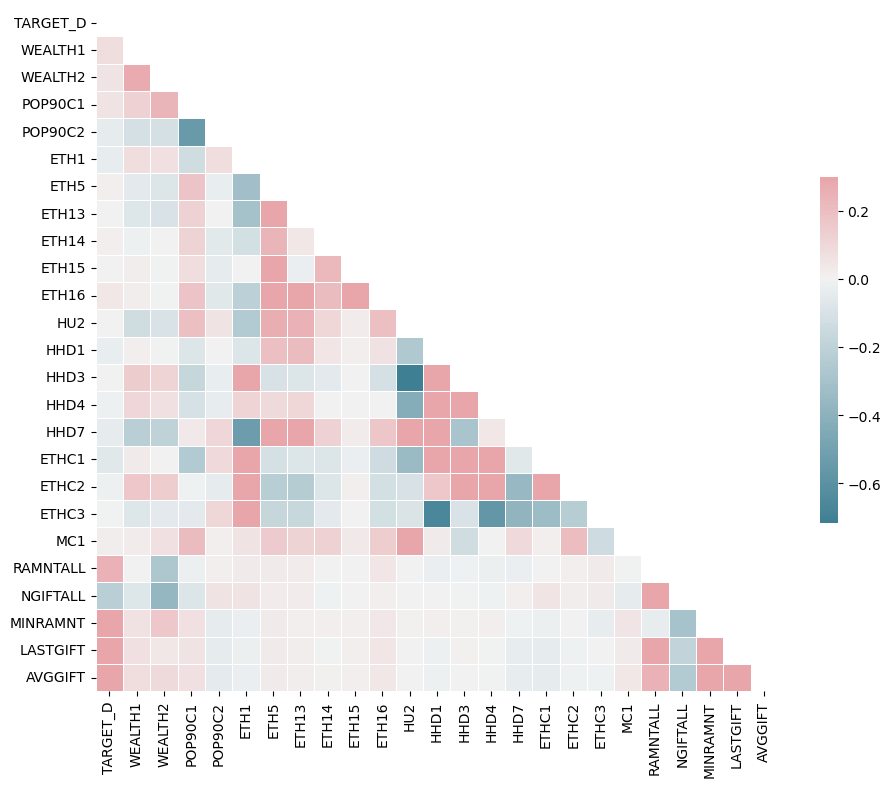

In [276]:
display_heatmap(pd.concat([targets[['TARGET_D']], numericals_rfe_manual_drop], axis=1))

#### `OLS`

In [271]:
df = sm.add_constant(numericals_scaled)

# Fit the OLS model
model = sm.OLS(targets[['TARGET_D']], df)
results = model.fit()

# Get the p-values of the features
pvalues = results.pvalues

# Select the features with a p-value more than 0.05
columns_to_drop = [col_tuple[0] for col_tuple in zip(numericals.columns, pvalues[1::]) if col_tuple[1] > 0.05]
print(f"There are '{len(columns_to_drop)}' columns to drop.")

There are '286' columns to drop.


In [272]:
columns_to_drop = [col for col in columns_to_drop if col not in important_columns]
numericals_ols = numericals.drop(columns_to_drop, axis=1)
numericals_ols.shape

(4843, 32)

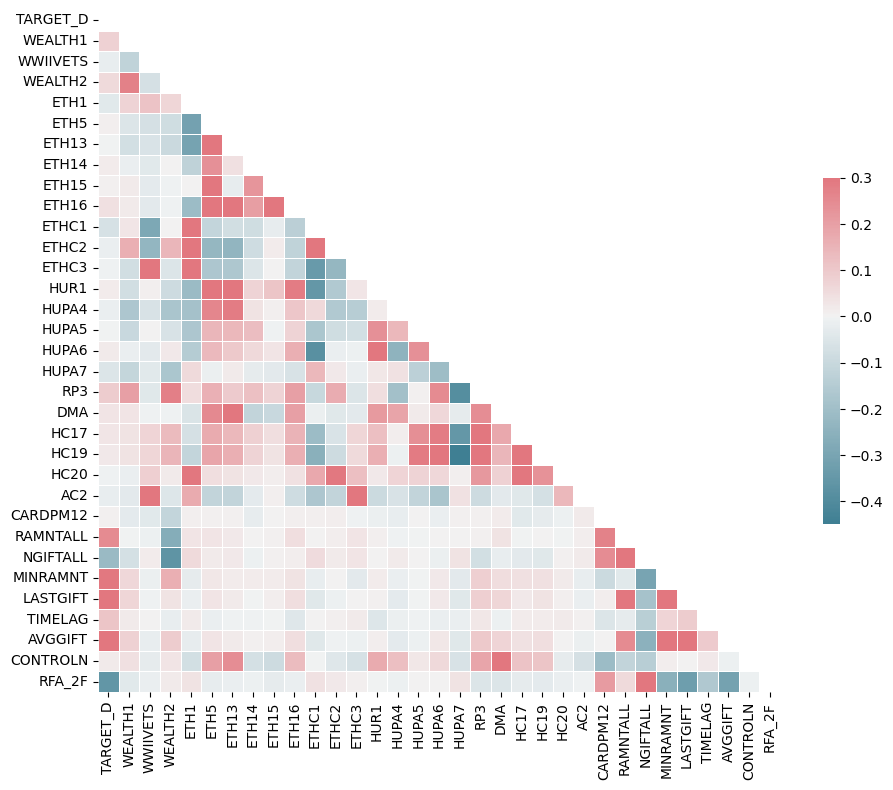

In [280]:
display_heatmap(pd.concat([targets[['TARGET_D']], numericals_ols], axis=1))

### `Compare models and feature selections`

In [292]:
models_to_test = [
    LinearRegression(n_jobs=-1),
    KNeighborsRegressor(n_jobs=-1),
    MLPRegressor(random_state=10),
    Lasso(random_state=10),
    Ridge(random_state=10),
    ElasticNet(random_state=10),
    RandomForestRegressor(n_jobs=-1, random_state=10),
    XGBRegressor(),
    LGBMRegressor(n_jobs=-1, random_state=10)
]

#### `Variance Threshold`

In [ ]:
# numericals_variance

variance_results = compare_models_target_d(models_to_test, numericals_variance)

In [ ]:
# ====== LGBMRegressor() ======
# R2: 0.3179202020545242
# Mean Squared Error: 96.13018482939877
# Mean Absolute Error: 5.795584989704034

In [ ]:
# numericals_variance_manual_drop

variance_manual_drop_results = compare_models_target_d(models_to_test, numericals_variance_manual_drop)

In [ ]:
# ====== LGBMRegressor() ======
# R2: 0.30658371040666976
# Mean Squared Error: 97.72791436296325
# Mean Absolute Error: 5.796645176085272

#### `RFE`

In [ ]:
# numericals_rfe

rfe_results = compare_models_target_d(models_to_test, numericals_rfe)

In [ ]:
# ====== LGBMRegressor() ======
# R2: 0.18040534458106772
# Mean Squared Error: 115.5110970122993
# Mean Absolute Error: 6.524267532730783

In [ ]:
# numericals_rfe_manual_drop

numericals_rfe_manual_drop_results = compare_models_target_d(models_to_test, numericals_rfe_manual_drop)

In [ ]:
# ====== LGBMRegressor() ======
# R2: 0.1872650040811138
# Mean Squared Error: 114.5443181433276
# Mean Absolute Error: 6.447675952509639

#### `OLS`

In [ ]:
# numericals_ols

numericals_ols_results = compare_models_target_d(models_to_test, numericals_ols)

In [ ]:
# ====== LGBMRegressor() ======
# R2: 0.1938699833060512
# Mean Squared Error: 113.61343311257298
# Mean Absolute Error: 6.218143516940545

#### `No feature selection`

In [290]:
models_to_test = [
    LinearRegression(n_jobs=-1),
    KNeighborsRegressor(n_jobs=-1),
    MLPRegressor(),
    Lasso(),
    Ridge(),
    ElasticNet(),
    RandomForestRegressor(n_jobs=-1),
    XGBRegressor(),
    LGBMRegressor(n_jobs=-1)
]

In [ ]:
# all numericals

all_numericals_results = compare_models_target_d(models_to_test, numericals)

In [ ]:
# ====== LGBMRegressor() ======
# R2: 0.21295941427261134
# Mean Squared Error: 110.92302865750632
# Mean Absolute Error: 6.187717834409587

### `Features selected by Variance Threshold and LGBMRegressor model perform better so we try to optimise parameters`

In [306]:
grid = {
    'boosting_type': ['gbdt', 'dart', 'rf'],
    'class_weight': [None, 'balanced'],
    'importance_type': ['split', 'gain']
}

grid_search_LGBMRegressor = find_best_parameters_target_d(LGBMRegressor(n_jobs=-1, random_state=10), numericals_variance, grid)

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /tmp/pip-req-build-u3yb2eqd/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /tmp/pip-req-build-u3yb2eqd/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /tmp/pip-req-build-u3yb2eqd/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /tmp/pip-req-build-u3yb2eqd/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /tmp/pip-req-build-u3yb2eqd/compile/src/boosting/rf.hpp, line 35 .

[Ligh

Best parameters: {'boosting_type': 'dart', 'class_weight': None, 'importance_type': 'split'}
Best score: 0.2672327067257543


### `Compare default LGBMRegressor model with best parameters`

In [307]:
models_to_test = [
    LGBMRegressor(n_jobs=-1, random_state=10),
    LGBMRegressor(n_jobs=-1, random_state=10, boosting_type='dart', class_weight=None, importance_type='split')
]

LGBMRegressor_results = compare_models_target_d(models_to_test, numericals_variance)

====== LGBMRegressor(random_state=10) ======
R2: 0.3179202020545242
Mean Squared Error: 96.13018482939877
Mean Absolute Error: 5.795584989704034
====== LGBMRegressor(boosting_type='dart', random_state=10) ======
R2: 0.3371051524826687
Mean Squared Error: 93.42631816137028
Mean Absolute Error: 5.449918895170622


### `Test on 'real data' - TARGET_D`

In [315]:
def compare_predicted_vs_target_D(model, selected_numericals):
    predictions = model.predict(pd.concat([selected_numericals, categoricals], axis=1).dropna(axis=0).values)
    df = pd.concat([targets[['TARGET_D']],pd.Series(predictions, name='TARGET_D_PREDICTED')],axis=1)

    print(f"Sum TARGET_D: {df['TARGET_D'].sum()}")
    print(f"Sum TARGET_D_PREDICTED: {df['TARGET_D_PREDICTED'].sum()}")

In [316]:
# LGBMRegressor(random_state=10)

compare_predicted_vs_target_D(LGBMRegressor_results[0], numericals_variance)

Sum TARGET_D: 75668.7
Sum TARGET_D_PREDICTED: 73336.6527592548


In [317]:
# LGBMRegressor(boosting_type='dart', random_state=10)

compare_predicted_vs_target_D(LGBMRegressor_results[1], numericals_variance)

Sum TARGET_D: 75668.7
Sum TARGET_D_PREDICTED: 52748.21865967616


### `Save TARGET_D models`

In [318]:
current_date = datetime.now().strftime("%Y-%m-%d %H-%M")

with open(f'models/LGBMRegressor_0_{current_date}.pkl', 'wb') as f:
    pickle.dump(LGBMRegressor_results[0], f)

In [319]:
current_date = datetime.now().strftime("%Y-%m-%d %H-%M")

with open(f'models/LGBMRegressor_1_{current_date}.pkl', 'wb') as f:
    pickle.dump(LGBMRegressor_results[1], f)